In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint
from sklearn.model_selection import LeaveOneOut, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from tqdm import tqdm

In [2]:
# Загрузка предобработанных данных
root = "../.."
input_path = f"{root}/data/processed"

scaled_droplet_size_data = pd.read_csv(f"{input_path}/scaled/droplet_size.csv")
encoded_droplet_size_data  = pd.read_csv(f"{input_path}/encoded/droplet_size.csv")
catboost_droplet_size_data = pd.read_csv(f"{input_path}/catboost/droplet_size.csv")

In [3]:
def evaluate_kfold(X, y, model, model_name, n_splits=10, cat_features=None):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    y_true, y_pred = [], []
    for tr, te in tqdm(kf.split(X), total=n_splits, desc=f"{model_name} {n_splits}-fold"):
        X_tr, X_te = X.iloc[tr], X.iloc[te]
        y_tr, y_te = y.iloc[tr], y.iloc[te]
        if cat_features and model_name.lower().startswith("catboost"):
            model.fit(X_tr, y_tr, cat_features=cat_features, verbose=False)
        else:
            model.fit(X_tr, y_tr)
        y_pred.extend(model.predict(X_te))
        y_true.extend(y_te.values)

    r2 = r2_score(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)

    plt.figure(figsize=(12, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.7)
    mn, mx = min(y_true), max(y_true)
    plt.plot([mn, mx], [mn, mx], 'k--', lw=2)
    plt.title(f"{model_name} — {n_splits}-fold\nR²: {r2:.3f} | RMSE: {rmse:.3f}")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return r2, rmse

In [4]:
# Разделение признаков и целевой переменной
X_scaled = scaled_droplet_size_data.drop(columns=["experiment.results.droplet_size.value"])
y_scaled = scaled_droplet_size_data["experiment.results.droplet_size.value"]

X_encoded  = encoded_droplet_size_data .drop(columns=["experiment.results.droplet_size.value"])
y_encoded  = encoded_droplet_size_data ["experiment.results.droplet_size.value"]

X_catboost = catboost_droplet_size_data.drop(columns=["experiment.results.droplet_size.value"])
y_catboost = catboost_droplet_size_data["experiment.results.droplet_size.value"]

# Выделение категориальных признаков для CatBoost
catboost_features = X_catboost.select_dtypes(include=["object", "category"]).columns.tolist()
X_catboost[catboost_features] = X_catboost[catboost_features].fillna('nan')

results = {}

Linear Regression 10-fold: 100%|██████████| 10/10 [00:00<00:00, 62.24it/s]


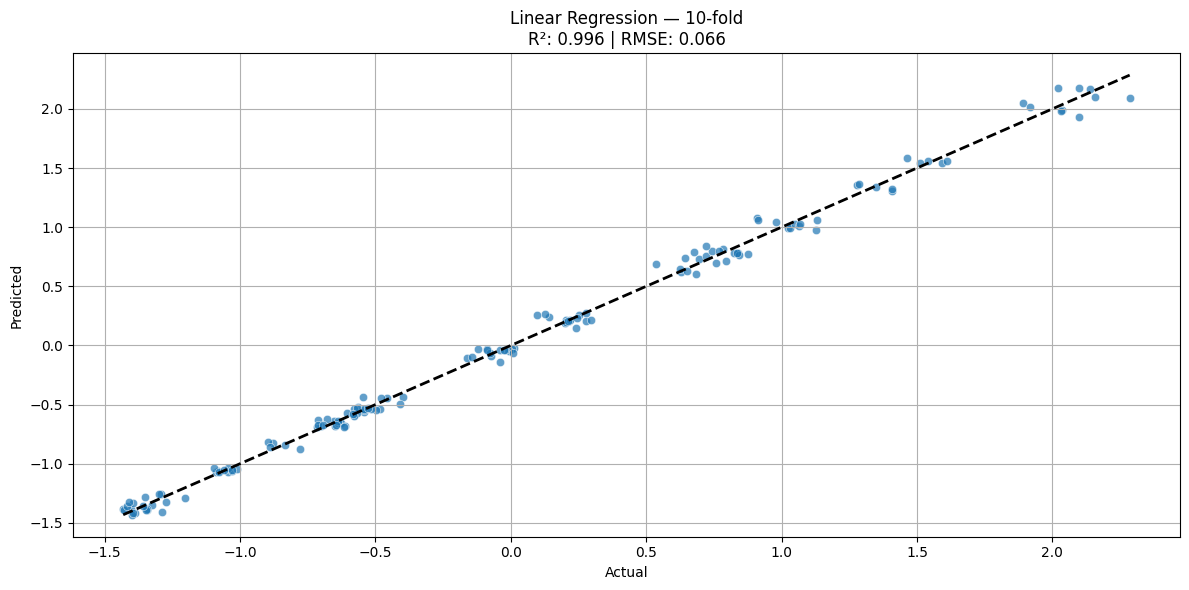

In [5]:
results["LinearRegression"] = evaluate_kfold(X_scaled, y_scaled, LinearRegression(), "Linear Regression")

In [6]:
# Подбор гиперпараметров для SVR
param_grid = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': np.logspace(-2, 3, 6),        # 0.01, 0.1, 1, 10, 100, 1000
    'epsilon': np.logspace(-3, -1, 3), # 0.001, 0.01, 0.1
    'gamma': ['scale', 'auto'] + list(np.logspace(-3, 1, 5))  # scale, auto и значения от 0.001 до 10
}

# Кросс-валидация
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Grid Search
grid_search = GridSearchCV(SVR(), param_grid, cv=cv, scoring='r2', n_jobs=-1, verbose=2)
grid_search.fit(X_scaled, y_scaled)

# Результаты
print("Best parameters:", grid_search.best_params_)
print("Best R2 score (KFold):", grid_search.best_score_)

Fitting 10 folds for each of 504 candidates, totalling 5040 fits
Best parameters: {'C': np.float64(100.0), 'epsilon': np.float64(0.01), 'gamma': 'scale', 'kernel': 'linear'}
Best R2 score (KFold): 0.9951718078576214


In [7]:
# Подбор гиперпараметров для SVR
param_grid = {
    'kernel': ['linear'],
    'C': np.logspace(1, 3, 10),        
    'epsilon': np.logspace(-3, -1, 10),
    'gamma': ['scale']
}

# Кросс-валидация
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Grid Search
grid_search = GridSearchCV(SVR(), param_grid, cv=cv, scoring='r2', n_jobs=-1, verbose=2)
grid_search.fit(X_scaled, y_scaled)

# Результаты
print("Best parameters:", grid_search.best_params_)
print("Best R2 score (KFold):", grid_search.best_score_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best parameters: {'C': np.float64(16.68100537200059), 'epsilon': np.float64(0.007742636826811269), 'gamma': 'scale', 'kernel': 'linear'}
Best R2 score (KFold): 0.9953089496180327


SVR 10-fold: 100%|██████████| 10/10 [00:00<00:00, 13.11it/s]


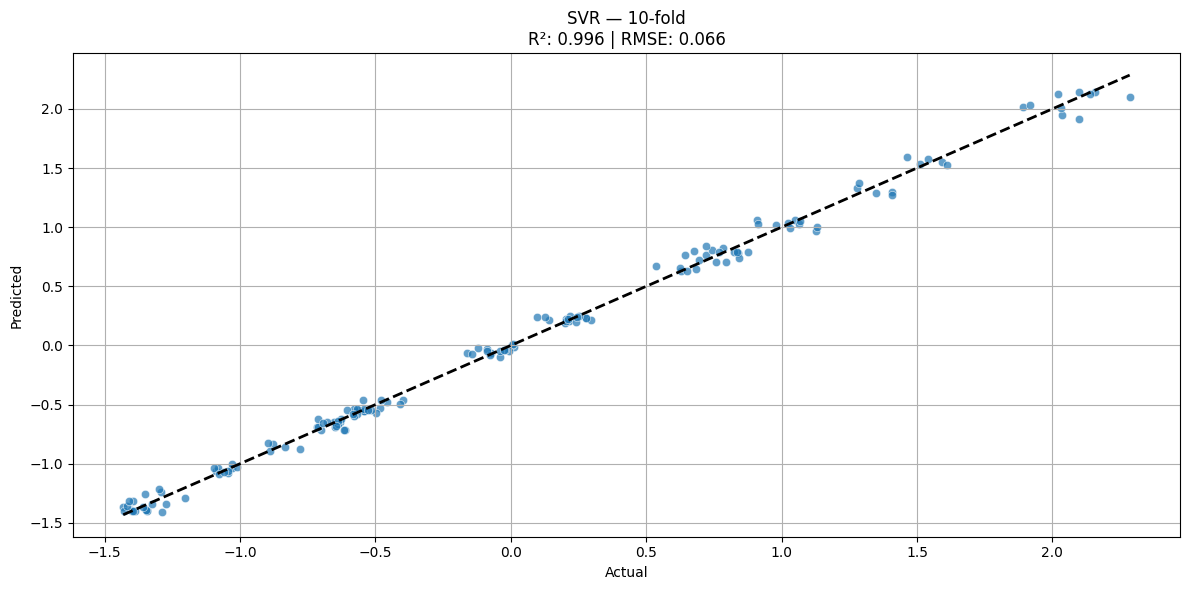

In [8]:
results["SVR"] = evaluate_kfold(X_scaled, y_scaled, SVR(**grid_search.best_params_), "SVR")

Random Forest 10-fold: 100%|██████████| 10/10 [00:03<00:00,  2.77it/s]


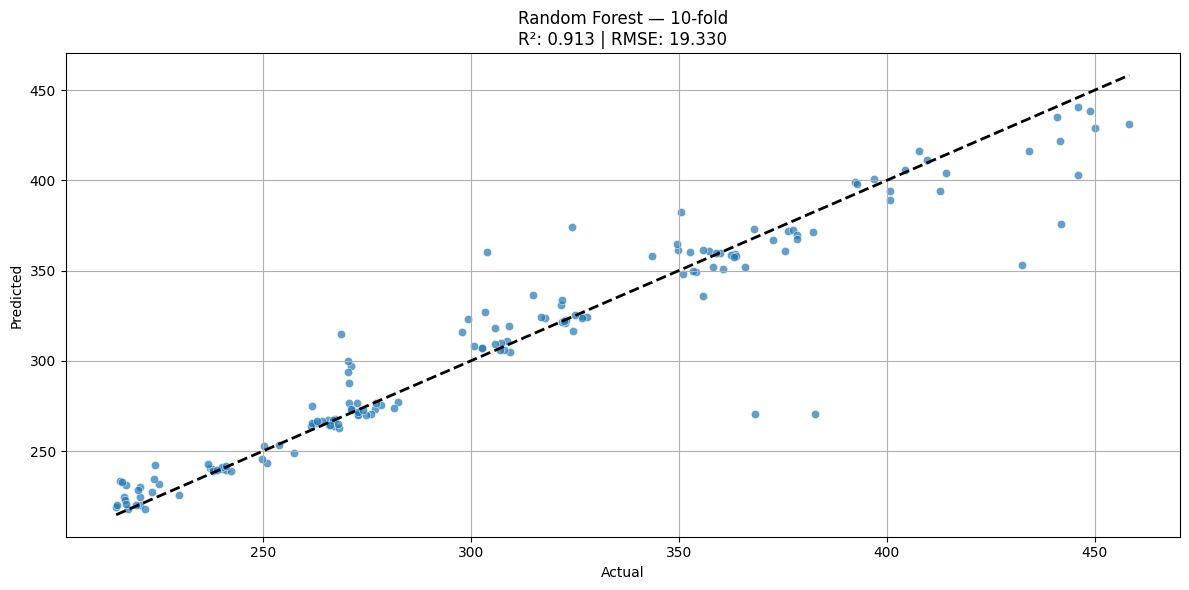

In [9]:
results["RandomForest"] = evaluate_kfold(X_encoded , y_encoded , RandomForestRegressor(), "Random Forest")

Gradient Boosting 10-fold: 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]


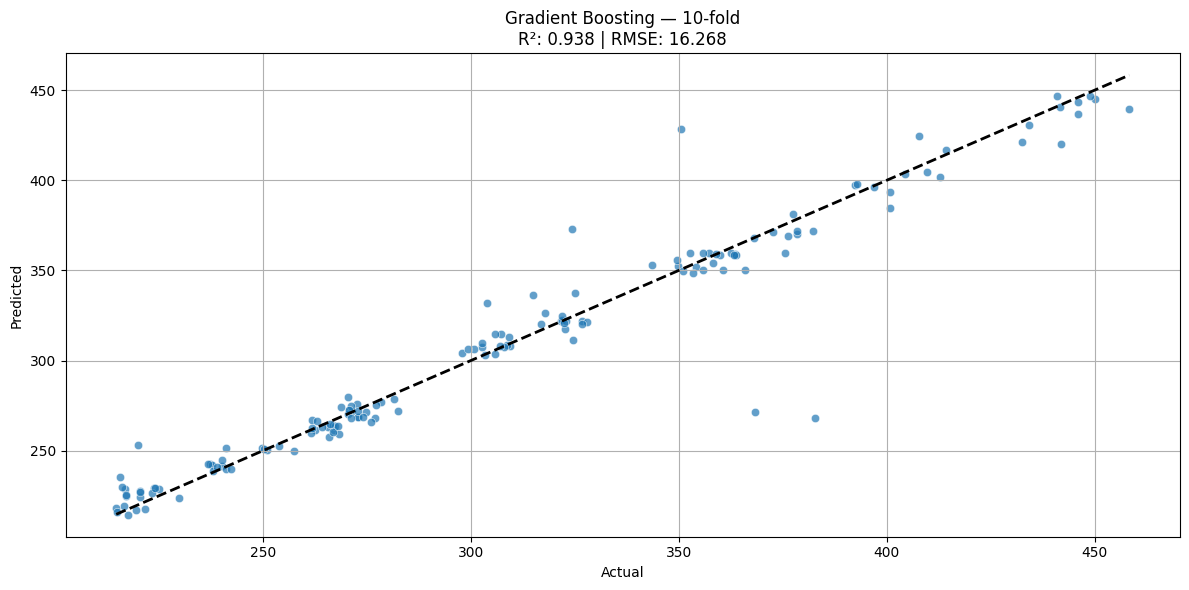

In [10]:
results["GradientBoosting"] = evaluate_kfold(X_encoded , y_encoded , GradientBoostingRegressor(), "Gradient Boosting")

XGBoost 10-fold: 100%|██████████| 10/10 [00:01<00:00,  5.15it/s]


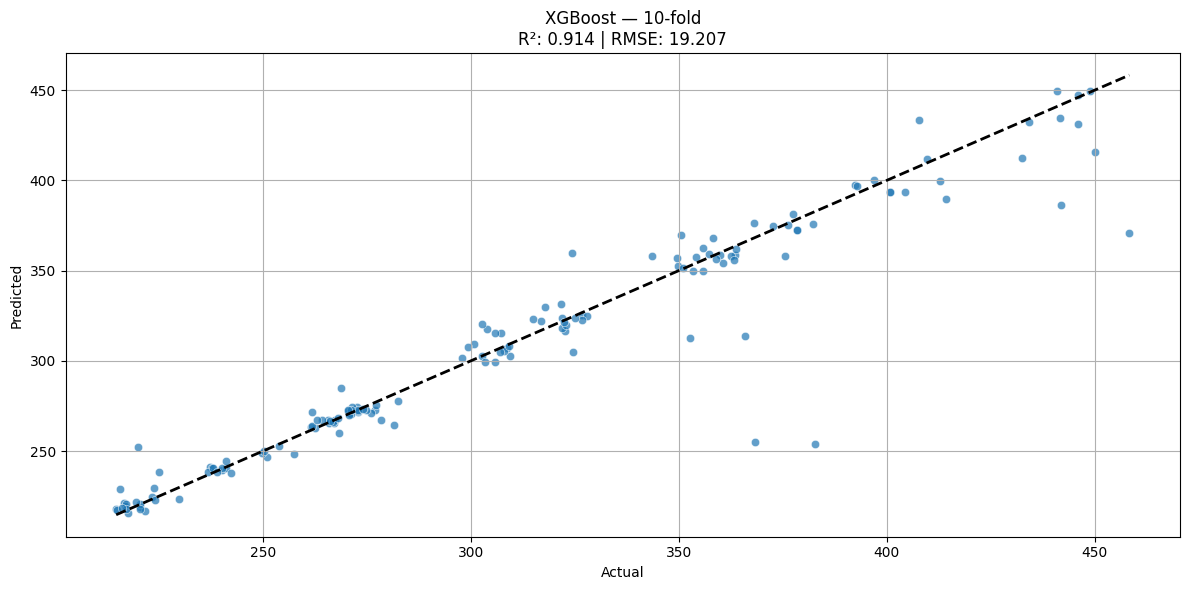

In [11]:
results["XGBoost"] = evaluate_kfold(X_encoded , y_encoded , XGBRegressor(), "XGBoost")

CatBoost 10-fold: 100%|██████████| 10/10 [05:41<00:00, 34.14s/it]


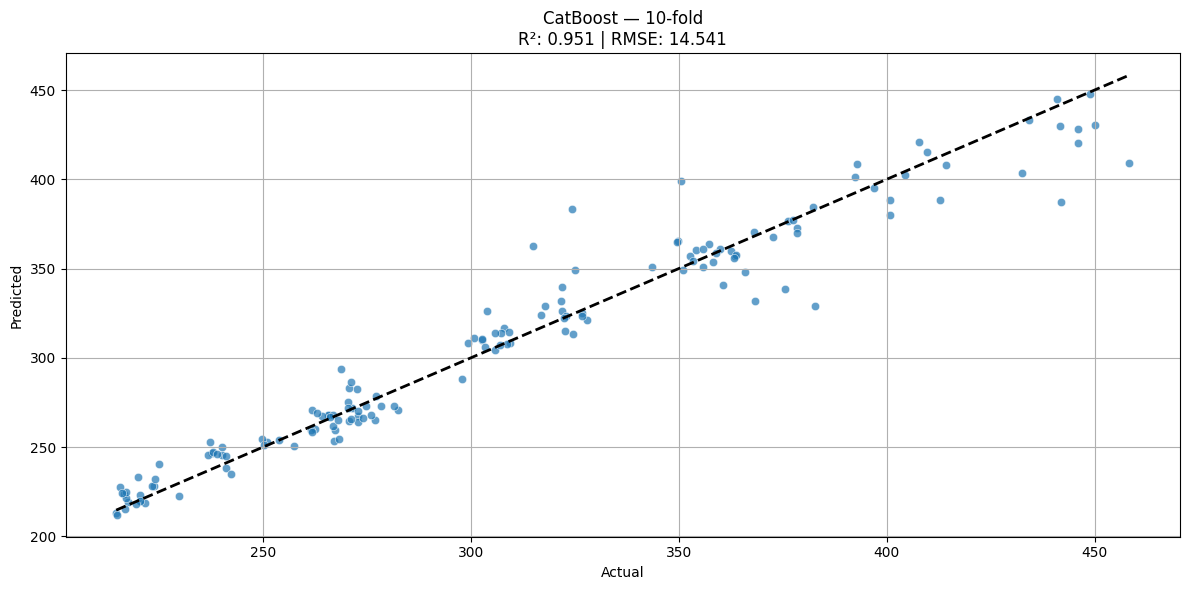

In [12]:
results["CatBoost"] = evaluate_kfold(X_catboost, y_catboost, 
                                              CatBoostRegressor(), 
                                              "CatBoost",
                                              cat_features=catboost_features)

In [13]:
df_results = pd.DataFrame.from_dict(results, orient='index', columns=['R2', 'MAE'])
df_results = df_results.reset_index().rename(columns={'index': 'Model'})
df_results = df_results.sort_values(by='R2', ascending=False)
df_results 

,Model,R2,MAE
1,SVR,0.995687,0.065672
0,LinearRegression,0.995616,0.066213
5,CatBoost,0.950789,14.540834
3,GradientBoosting,0.938407,16.267715
4,XGBoost,0.914140,19.206809
2,RandomForest,0.913031,19.330451


По данным по задаче восстановления регрессии размера капель видно, что линейные и близкие к ним по идее модели оказываются заметно точнее и стабильнее, чем сложные ансамбли деревьев:

1. **SVR и линейная регрессия** показывают практически идентичные результаты: R² ≈ 0.9956–0.9957 и MAE ≈ 0.0657–0.0662. Это означает, что более чем 99 % дисперсии величины droplet\_size объясняется выбранными признаками, а средняя абсолютная ошибка составляет всего несколько сотых единицы (вероятно, миллиметра или микрометра в зависимости от шкалы). Такая точность говорит о том, что зависимость между признаками и размером капель почти линейна, и обе эти модели отлично с ней справляются.

2. **Ансамбли деревьев** (CatBoost, GradientBoosting, XGBoost, RandomForest) демонстрируют существенно худшую производительность:

   * R² варьируется от 0.95 (CatBoost) до \~0.91 (XGBoost, RandomForest), то есть они объясняют лишь 91–95 % дисперсии.
   * MAE в диапазоне 14–19 единиц (опять же в тех же условных единицах) — это в сотни раз больше ошибки линейных моделей.

Такой разрыв, скорее всего, объясняется тем, что деревья сходу «огрубляют» прогноз и плохо моделируют мелкие линейные колебания, которые важны при оценке размера капель. Кроме того, возможно, для ансамблей недостаточно тонкая настройка гиперпараметров (например, глубины деревьев, регуляризации), или данные содержат мало сложных нелинейных связей, которые дереву действительно стоило бы уловить.

**Выводы:**

* Для задачи предсказания droplet\_size наиболее оправданы SVR или простая линейная регрессия: они дают минимальную погрешность и не требуют сложной настройки.
* Использование ансамблей деревьев здесь избыточно: они в текущей конфигурации не достигают нужной точности и, скорее всего, приведут к переобучению на шуме или слишком «жёсткому» разбиению пространства признаков.
* Возможно стоит провести тонкий подбор гиперпараметров (мелкая глубина, сильная регуляризация, увеличение числа деревьев) и при необходимости сконцентрироваться на преобразовании признаков, которые лучше «откроют» нелинейные зависимости.
* В целом, учитывая текущие результаты, SVR и линейная регрессия — обеспечивают высокую точность, устойчивость и простоту интерпретации.
